<a href="https://colab.research.google.com/github/Abdulaziz-Sherif/Special-Topics-Research/blob/main/Special_Topics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [479]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import sigmoid, relu, tanh
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

import warnings

warnings.filterwarnings('ignore')

In [412]:
gt_vaccine_bydate = pd.read_csv('/content/multiTimeline (2).csv')
gt_vaccine_bydate.head()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster
0,2020-12-13,20,0.0,3.0,0.1
1,2020-12-20,12,0.0,1.0,0.0
2,2020-12-27,14,0.0,1.0,0.0
3,2021-01-03,15,0.0,1.0,0.0
4,2021-01-10,18,0.1,2.0,0.0


In [413]:
# Convert the 'Week' column to datetime format
gt_vaccine_bydate['Week'] = pd.to_datetime(gt_vaccine_bydate['Week'])

# Change weeks to 2 weeks later to correspond with the lag and vaccination data
gt_vaccine_bydate['One_Week_Later'] = gt_vaccine_bydate['Week'] + timedelta(weeks=2)

# Display the result
print(gt_vaccine_bydate[['Week', 'One_Week_Later']])

          Week One_Week_Later
0   2020-12-13     2020-12-27
1   2020-12-20     2021-01-03
2   2020-12-27     2021-01-10
3   2021-01-03     2021-01-17
4   2021-01-10     2021-01-24
..         ...            ...
150 2023-10-29     2023-11-12
151 2023-11-05     2023-11-19
152 2023-11-12     2023-11-26
153 2023-11-19     2023-12-03
154 2023-11-26     2023-12-10

[155 rows x 2 columns]


In [414]:
gt_vaccine_bydate.tail()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,One_Week_Later
150,2023-10-29,6,1.0,1.0,1.0,2023-11-12
151,2023-11-05,4,1.0,1.0,0.1,2023-11-19
152,2023-11-12,3,0.1,0.1,0.1,2023-11-26
153,2023-11-19,3,0.1,0.1,0.1,2023-12-03
154,2023-11-26,2,0.1,0.1,0.1,2023-12-10


In [415]:
vac_canada =pd.read_csv('/content/vaccination-coverage-map.csv')
vac_canada.head()

,week_end,pruid,prename,prfname,numtotal_atleast1dose,numtotal_partially,numtotal_fully,numtotal_onlyfully,numtotal_additional,numtotal_1additional,...,num12plus_vax_interest,prop12plus_atleast1dose,prop12plus_partially,prop12plus_fully,prop12plus_onlyfully,prop12plus_additional,prop12plus_1additional,prop12plus_2nd_additional,prop12plus_recommended_vax,prop12plus_vax_interest
0,2020-12-19,1,Canada,Canada,12368.0,12368.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-19,10,Newfoundland and Labrador,Terre-Neuve-et-Labrador,972.0,972.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-19,12,Nova Scotia,Nouvelle-Écosse,1092.0,1092.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-19,24,Quebec,Québec,4728.0,4728.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-19,46,Manitoba,Manitoba,894.0,894.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [416]:
#Rename week_end to date
vac_canada.rename(columns={'week_end': 'date'}, inplace=True)
# Convert the 'date' column to datetime format
vac_canada['date'] = pd.to_datetime(vac_canada['date'])

In [417]:
# Convert relevant columns to numeric data types
numeric_columns = ['proptotal_atleast1dose', 'proptotal_fully', 'proptotal_additional', 'proptotal_recommended_vax']
vac_canada[numeric_columns] = vac_canada[numeric_columns].apply(pd.to_numeric, errors='coerce')
print(vac_canada[numeric_columns].dtypes)

proptotal_atleast1dose       float64
proptotal_fully              float64
proptotal_additional         float64
proptotal_recommended_vax    float64
dtype: object


In [418]:
# Group by region and calculate the differences within each group
grouped_vac_canada = vac_canada.groupby('prename')[numeric_columns].transform(lambda x: x.diff())

# Assign the calculated differences to new columns in the original DataFrame
vac_canada['change_prop_atleast1dose'] = grouped_vac_canada['proptotal_atleast1dose']
vac_canada['change_prop_fully'] = grouped_vac_canada['proptotal_fully']
vac_canada['change_prop_additional'] = grouped_vac_canada['proptotal_additional']
vac_canada['change_prop_recommended_vax'] = grouped_vac_canada['proptotal_recommended_vax']

print(vac_canada.head())

        date  pruid                    prename                  prfname  \
0 2020-12-19      1                     Canada                   Canada   
1 2020-12-19     10  Newfoundland and Labrador  Terre-Neuve-et-Labrador   
2 2020-12-19     12                Nova Scotia          Nouvelle-Écosse   
3 2020-12-19     24                     Quebec                   Québec   
4 2020-12-19     46                   Manitoba                 Manitoba   

   numtotal_atleast1dose  numtotal_partially  numtotal_fully  \
0                12368.0             12368.0             0.0   
1                  972.0               972.0             0.0   
2                 1092.0              1092.0             0.0   
3                 4728.0              4728.0             0.0   
4                  894.0               894.0             0.0   

   numtotal_onlyfully  numtotal_additional  numtotal_1additional  ...  \
0                 NaN                  NaN                   NaN  ...   
1                 

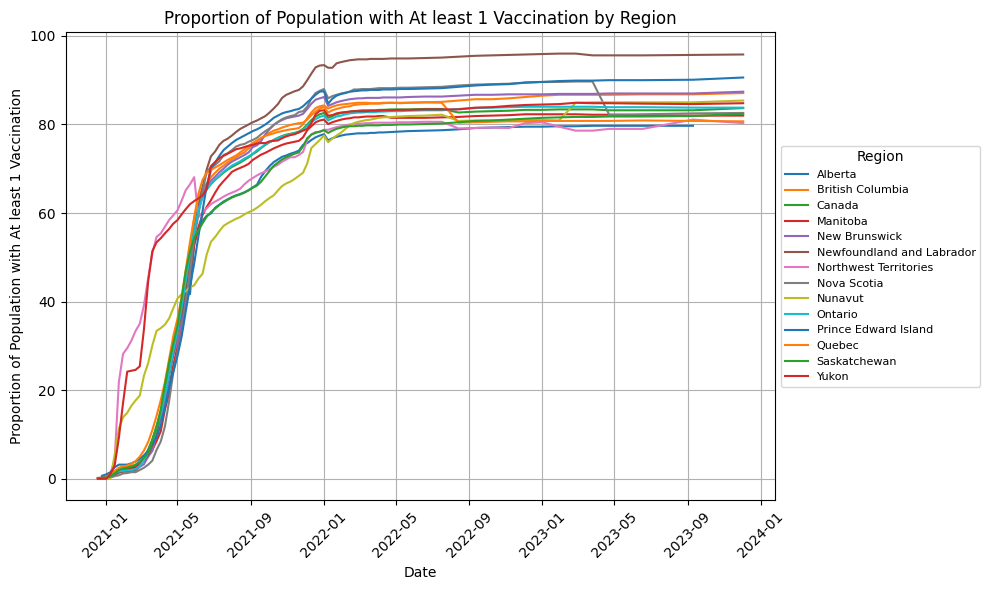

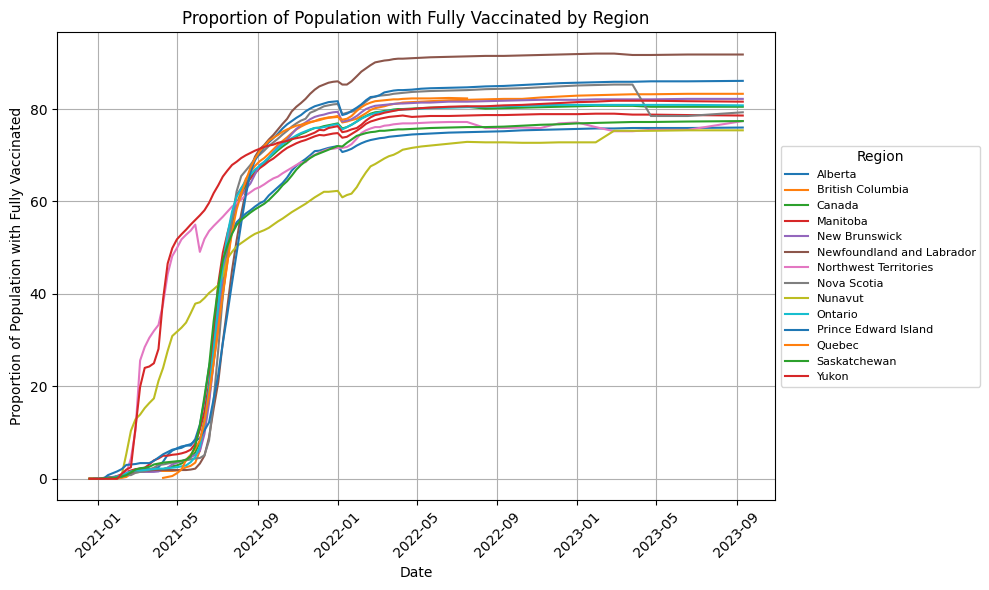

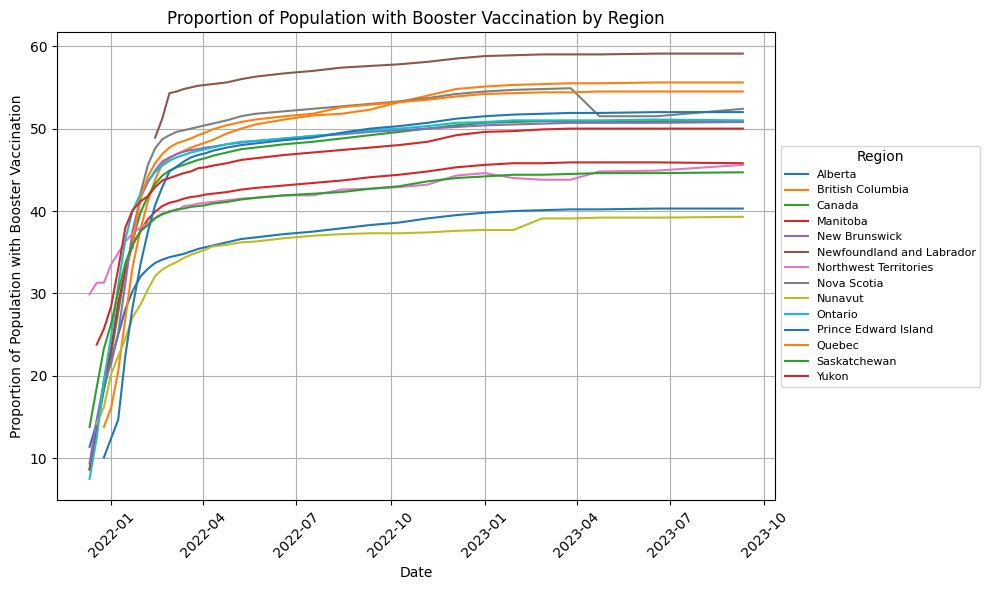

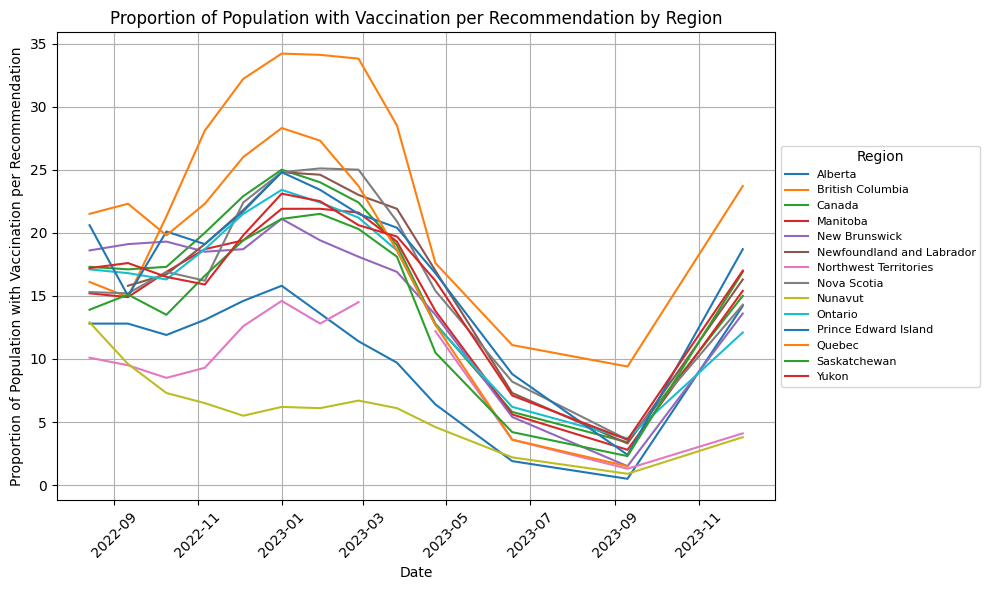

In [419]:
grouped_vac_canada = vac_canada.groupby('prename')

# Define a dictionary to map old column names to new column names
column_name_mapping = {
    'proptotal_atleast1dose': 'At least 1 Vaccination',
    'proptotal_fully': 'Fully Vaccinated',
    'proptotal_additional': 'Booster Vaccination',
    'proptotal_recommended_vax': 'Vaccination per Recommendation'
}
columns_of_interest = ['proptotal_atleast1dose', 'proptotal_fully', 'proptotal_additional', 'proptotal_recommended_vax']

# Plot each column against date for each group
for column in columns_of_interest:
    plt.figure(figsize=(10, 6))
    for name, group in grouped_vac_canada:
        plt.plot(group['date'], group[column], label=name)
    # Add labels and legend
    plt.title(f'Proportion of Population with {column_name_mapping[column]} by Region')
    plt.xlabel('Date')
    plt.ylabel(f'Proportion of Population with {column_name_mapping[column]}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Region', loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})
    plt.tight_layout()
    plt.show()


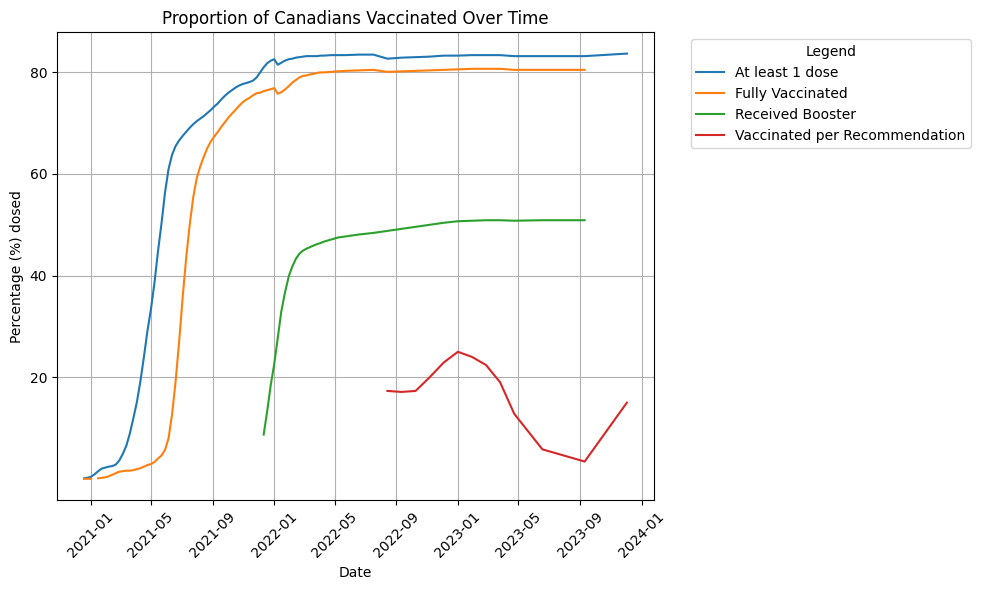

In [322]:
#remove provinces from data
canada_df = vac_canada[vac_canada['prename'] == 'Canada']

# Define the variables to plot
variables = ['proptotal_atleast1dose', 'proptotal_fully', 'proptotal_additional', 'proptotal_recommended_vax']
labels = ['At least 1 dose', 'Fully Vaccinated', 'Received Booster', 'Vaccinated per Recommendation']

# Create a plot for each variable
plt.figure(figsize=(10, 6))
for variable, label in zip(variables, labels):
    # Plot the percentage change for the current variable
    plt.plot(canada_df['date'], canada_df[variable], linestyle='-', label=label)

# Add labels and legend
plt.title('Proportion of Canadians Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage (%) dosed')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks([20, 40, 60, 80], ['20', '40', '60', '80'])
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')
plt.tight_layout()
plt.show()

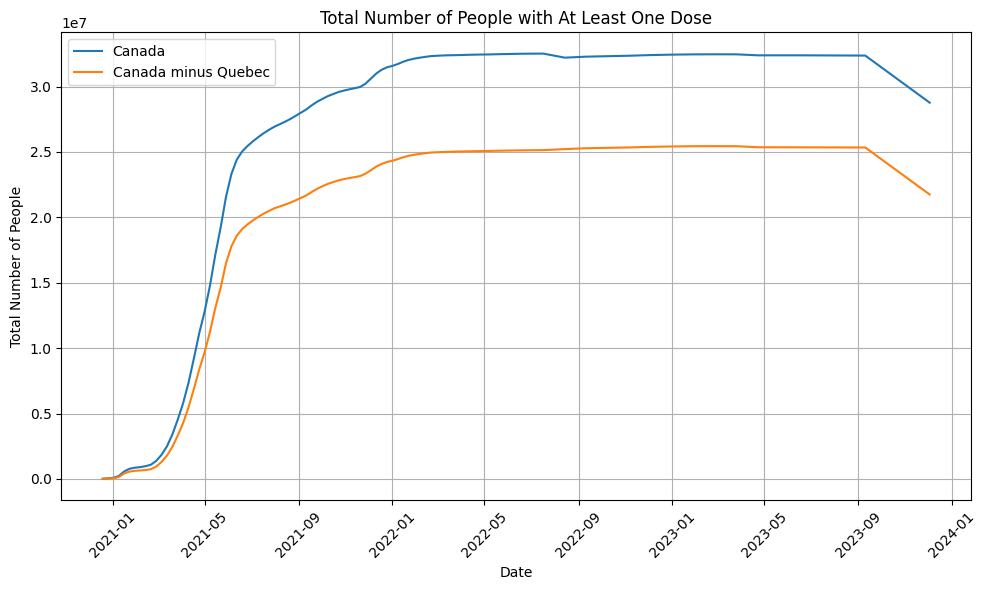

In [420]:
grouped_data = vac_canada.groupby('date')

# Calculate the difference between Quebec and Canada for numtotal_atleast1dose
difference_data = grouped_data.apply(lambda x: x[x['prename'] == 'Canada']['numtotal_atleast1dose'].iloc[0] - x[x['prename'] == 'Quebec']['numtotal_atleast1dose'].iloc[0])

# Create a new DataFrame to store the calculated differences
new_rows = pd.DataFrame(columns=vac_canada.columns)

# Iterate over each date and add a new row with the calculated difference
for date, difference in difference_data.items():
    canada_row = vac_canada[(vac_canada['prename'] == 'Canada') & (vac_canada['date'] == date)].iloc[0]
    new_row = canada_row.copy()
    new_row['prename'] = 'Canada minus Quebec'
    new_row['numtotal_atleast1dose'] = difference
    new_rows = new_rows.append(new_row, ignore_index=True)

# Append the new rows to the original DataFrame
vac_canada = pd.concat([vac_canada, new_rows], ignore_index=True)

# Sort the DataFrame by date
vac_canada = vac_canada.sort_values(by='date')

# Plot the difference over time
plt.figure(figsize=(10, 6))
plt.plot(vac_canada[vac_canada['prename'] == 'Canada']['date'], vac_canada[vac_canada['prename'] == 'Canada']['numtotal_atleast1dose'], label='Canada')
plt.plot(vac_canada[vac_canada['prename'] == 'Canada minus Quebec']['date'], vac_canada[vac_canada['prename'] == 'Canada minus Quebec']['numtotal_atleast1dose'], label='Canada minus Quebec')
plt.title('Total Number of People with At Least One Dose')
plt.xlabel('Date')
plt.ylabel('Total Number of People')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

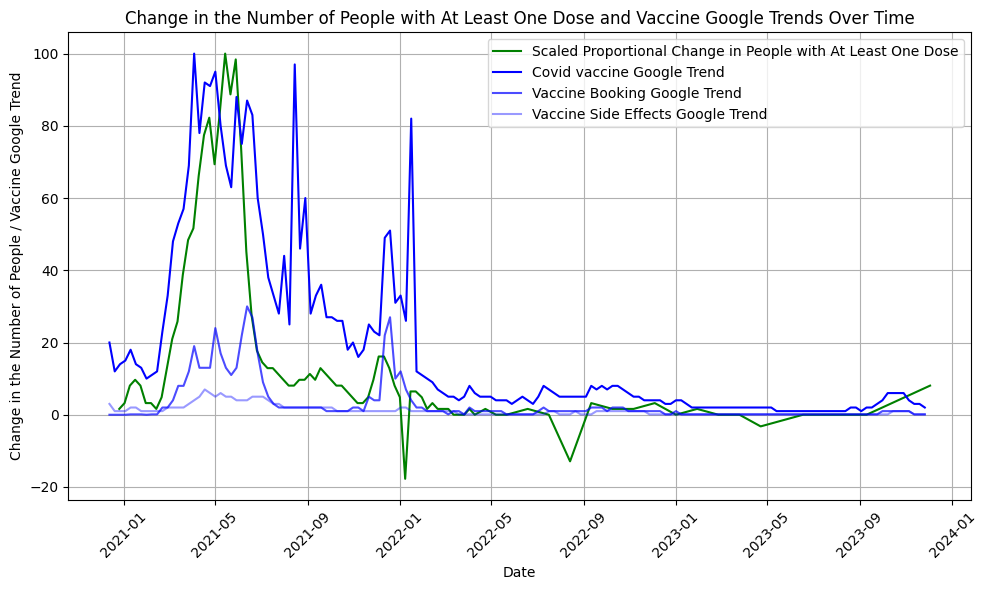

In [421]:
# Find the maximum value in the column
max_value = canada_df['change_prop_atleast1dose'].max()
# Divide all values by the maximum value and multiply by 100% to put them on the same scale
canada_df['normalized_change_prop_atleast1dose'] = canada_df['change_prop_atleast1dose'] / max_value
canada_df['normalized_change_prop_atleast1dose'] *= 100

# Plot the scaled change in the total number of people with at least one dose over time
plt.figure(figsize=(10, 6))
plt.plot(canada_df['date'], canada_df['normalized_change_prop_atleast1dose'], linestyle='-', label='Scaled Proportional Change in People with At Least One Dose', color='green')

# Overlay the vaccine google trends data
plt.plot(gt_vaccine_bydate['Week'], gt_vaccine_bydate['Covid vaccine'], linestyle='-', label='Covid vaccine Google Trend', color='blue')
plt.plot(gt_vaccine_bydate['Week'], gt_vaccine_bydate['Vaccine Booking'], linestyle='-', label='Vaccine Booking Google Trend', color='blue', alpha=0.7)
plt.plot(gt_vaccine_bydate['Week'], gt_vaccine_bydate['vaccine side effects'], linestyle='-', label='Vaccine Side Effects Google Trend', color='blue', alpha=0.4)

# Add labels and legend
plt.title('Change in the Number of People with At Least One Dose and Vaccine Google Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Change in the Number of People / Vaccine Google Trend')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

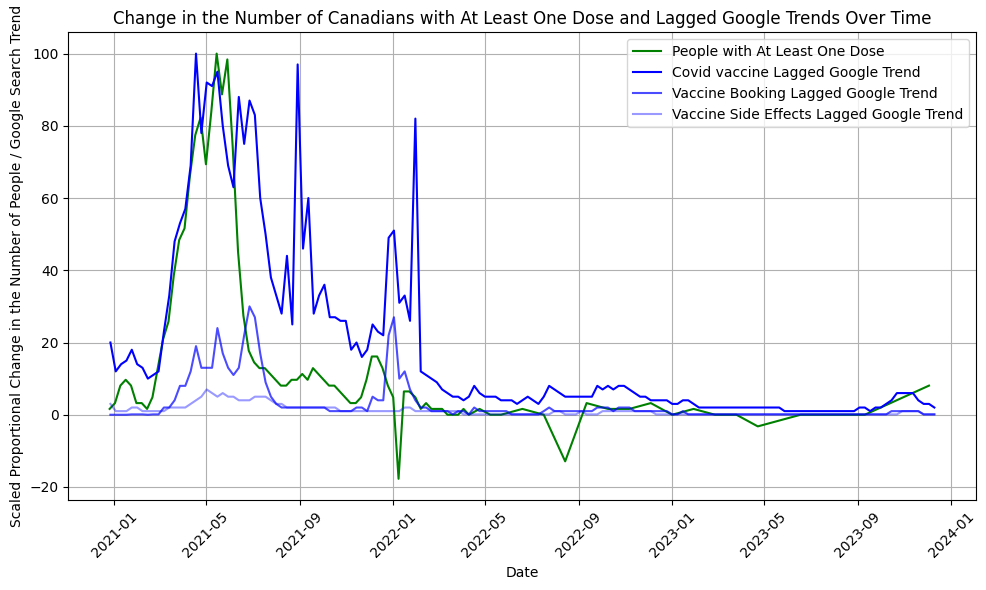

In [422]:
# Plot the scaled change in the total number of people with at least one dose over time
plt.figure(figsize=(10, 6))
plt.plot(canada_df['date'], canada_df['normalized_change_prop_atleast1dose'], linestyle='-', label='People with At Least One Dose', color='green')

# Overlay the vaccine google trends data
plt.plot(gt_vaccine_bydate['One_Week_Later'], gt_vaccine_bydate['Covid vaccine'], linestyle='-', label='Covid vaccine Lagged Google Trend', color='blue')
plt.plot(gt_vaccine_bydate['One_Week_Later'], gt_vaccine_bydate['Vaccine Booking'], linestyle='-', label='Vaccine Booking Lagged Google Trend', color='blue', alpha=0.7)
plt.plot(gt_vaccine_bydate['One_Week_Later'], gt_vaccine_bydate['vaccine side effects'], linestyle='-', label='Vaccine Side Effects Lagged Google Trend', color='blue', alpha=0.4)

# Add labels and legend
plt.title('Change in the Number of Canadians with At Least One Dose and Lagged Google Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Proportional Change in the Number of People / Google Search Trend')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

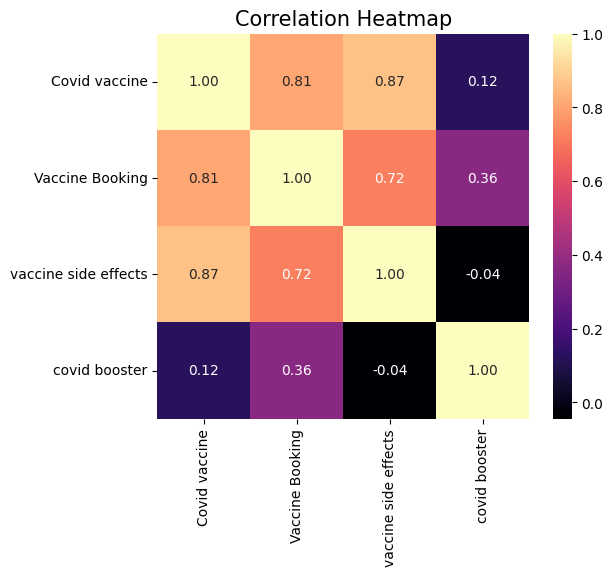

In [423]:
# Correlation matrix of selected google search trends
features = gt_vaccine_bydate[['Covid vaccine', 'Vaccine Booking', 'vaccine side effects', 'covid booster']]
correlation_matrix = features.corr()

# Plot the updated correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [424]:
# List of columns to keep
columns_to_keep = [
    'date',
    'prename',
    'numtotal_atleast1dose', 'numtotal_fully', 'numtotal_additional', 'numtotal_recommended_vax',
    'proptotal_atleast1dose', 'proptotal_fully', 'proptotal_additional', 'proptotal_recommended_vax',
    'change_prop_atleast1dose', 'change_prop_fully', 'change_prop_additional', 'change_prop_recommended_vax',
    'num12plus_atleast1dose', 'num12plus_fully', 'num12plus_additional', 'num12plus_recommended_vax',
    'prop12plus_atleast1dose', 'prop12plus_fully', 'prop12plus_additional', 'prop12plus_recommended_vax',
    'normalized_change_prop_atleast1dose'
]

# Keep only the specified columns
canada_df_cleaned = canada_df[columns_to_keep]

In [425]:
# Get the minimum and maximum dates from canada_df_cleaned
start_date = pd.to_datetime('2022-01-30')  # Change to your desired start date
end_date = canada_df_cleaned['date'].max()

# Generate a weekly date range from start_date to end_date
weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W')

# Create a DataFrame with the weekly dates
weekly_dates_df = pd.DataFrame({'date': weekly_dates})

# Concatenate the original canada_df_cleaned DataFrame with the DataFrame containing weekly dates
canada_df_cleaned_extended = pd.concat([canada_df_cleaned, weekly_dates_df]).sort_values(by='date').reset_index(drop=True)

print(canada_df_cleaned_extended['date'])

0     2020-12-19
1     2020-12-26
2     2021-01-02
3     2021-01-09
4     2021-01-16
         ...    
179   2023-11-12
180   2023-11-19
181   2023-11-26
182   2023-12-03
183   2023-12-03
Name: date, Length: 184, dtype: datetime64[ns]


In [426]:
# Offset dates in canada_df_filtered to the next day
canada_df_filtered = canada_df_cleaned_extended[canada_df_cleaned_extended['date'] <= '2022-01-23']
canada_df_filtered['date'] = canada_df_filtered['date'] + pd.DateOffset(days=1)

gt_vaccine_filtered = gt_vaccine_bydate[(gt_vaccine_bydate['One_Week_Later'] <= '2022-01-22')]
# Merge datasets for dates up to January 22, 2022
merged_data = pd.merge(gt_vaccine_filtered, canada_df_filtered, left_on='One_Week_Later', right_on='date', how='left')

merged_data.head()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,One_Week_Later,date,prename,numtotal_atleast1dose,numtotal_fully,...,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_atleast1dose,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
0,2020-12-13,20,0.0,3.0,0.1,2020-12-27,2020-12-27,Canada,46180.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.612903
1,2020-12-20,12,0.0,1.0,0.0,2021-01-03,2021-01-03,Canada,82530.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.225806
2,2020-12-27,14,0.0,1.0,0.0,2021-01-10,2021-01-10,Canada,217393.0,4527.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.064516
3,2021-01-03,15,0.0,1.0,0.0,2021-01-17,2021-01-17,Canada,564976.0,26769.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.677419
4,2021-01-10,18,0.1,2.0,0.0,2021-01-24,2021-01-24,Canada,775546.0,59309.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.064516


In [427]:
# Filter gt_vaccine_bydate for dates between January 23, 2022, and December 31, 2023
gt_vaccine_filtered = gt_vaccine_bydate[(gt_vaccine_bydate['One_Week_Later'] > '2022-01-23') & (gt_vaccine_bydate['One_Week_Later'] <= '2023-12-03')]
canada_df_filtered = canada_df_cleaned_extended[(canada_df_cleaned_extended['date'] > '2022-01-23') & (canada_df_cleaned_extended['date']<= '2023-12-03')]

# Merge datasets for dates between January 23, 2022, and April 10, 2022
merged_data_next = pd.merge(gt_vaccine_filtered, canada_df_filtered, left_on='One_Week_Later', right_on='date', how='left')

merged_data_next.tail()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,One_Week_Later,date,prename,numtotal_atleast1dose,numtotal_fully,...,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_atleast1dose,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
121,2023-10-29,6,1.0,1.0,1.0,2023-11-12,2023-11-12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,2023-11-05,4,1.0,1.0,0.1,2023-11-19,2023-11-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,2023-11-12,3,0.1,0.1,0.1,2023-11-26,2023-11-26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,2023-11-19,3,0.1,0.1,0.1,2023-12-03,2023-12-03,Canada,28769834.0,NaN,...,11.6,27434470.0,NaN,NaN,4386605.0,90.7,NaN,NaN,16.5,8.064516
125,2023-11-19,3,0.1,0.1,0.1,2023-12-03,2023-12-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
merged_data = merged_data.append(merged_data_next)
merged_data.tail()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,One_Week_Later,date,prename,numtotal_atleast1dose,numtotal_fully,...,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_atleast1dose,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
121,2023-10-29,6,1.0,1.0,1.0,2023-11-12,2023-11-12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,2023-11-05,4,1.0,1.0,0.1,2023-11-19,2023-11-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,2023-11-12,3,0.1,0.1,0.1,2023-11-26,2023-11-26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,2023-11-19,3,0.1,0.1,0.1,2023-12-03,2023-12-03,Canada,28769834.0,NaN,...,11.6,27434470.0,NaN,NaN,4386605.0,90.7,NaN,NaN,16.5,8.064516
125,2023-11-19,3,0.1,0.1,0.1,2023-12-03,2023-12-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [429]:
# Filter data from the start to April 10, 2022
firstdose_df = merged_data[merged_data['One_Week_Later'] <= '2022-04-10']

firstdose_df.tail()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,One_Week_Later,date,prename,numtotal_atleast1dose,numtotal_fully,...,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_atleast1dose,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
17,2022-03-13,5,1.0,1.0,1.0,2022-03-27,2022-03-27,Canada,32406499.0,31092563.0,...,NaN,30765933.0,29954685.0,17981967.0,NaN,90.1,87.7,52.7,NaN,0.000000
18,2022-03-20,4,1.0,0.1,1.0,2022-04-03,2022-04-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,2022-03-20,4,1.0,0.1,1.0,2022-04-03,2022-04-03,Canada,32417787.0,31130006.0,...,NaN,30779818.0,29972867.0,18075437.0,NaN,90.2,87.8,52.9,NaN,1.612903
20,2022-03-27,5,0.1,0.1,1.0,2022-04-10,2022-04-10,Canada,32428790.0,31158873.0,...,NaN,30790780.0,29986204.0,18169148.0,NaN,90.2,87.8,53.2,NaN,0.000000
21,2022-03-27,5,0.1,0.1,1.0,2022-04-10,2022-04-10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [430]:
#briefly look into the dataset
firstdose_df.describe()

,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,numtotal_atleast1dose,numtotal_fully,numtotal_additional,numtotal_recommended_vax,proptotal_atleast1dose,proptotal_fully,...,change_prop_additional,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
count,78.000000,78.000000,78.000000,78.000000,6.700000e+01,6.700000e+01,1.700000e+01,0.0,67.000000,66.000000,...,16.00000,0.0,4.400000e+01,4.400000e+01,1.700000e+01,0.0,44.000000,17.000000,0.0,67.000000
mean,34.935897,5.460256,2.030769,1.553846,2.140248e+07,1.695191e+07,1.320268e+07,NaN,55.680597,44.724242,...,2.15000,NaN,2.881944e+07,2.519051e+07,1.320228e+07,NaN,74.727273,41.200000,NaN,19.932595
std,28.861217,7.475993,1.596938,2.942951,1.206953e+07,1.323586e+07,6.004975e+06,NaN,31.287558,34.147644,...,2.05329,NaN,2.025685e+06,7.087079e+06,6.004801e+06,NaN,20.843485,14.732787,NaN,27.463454
min,4.000000,0.000000,0.100000,0.000000,4.618000e+04,0.000000e+00,1.979632e+06,NaN,0.200000,0.000000,...,0.20000,NaN,2.328382e+07,3.045303e+06,1.979502e+06,NaN,9.100000,10.000000,NaN,-17.741935
25%,11.250000,1.000000,1.000000,0.100000,1.016442e+07,9.753955e+05,7.950646e+06,NaN,26.550000,2.750000,...,0.30000,NaN,2.741348e+07,2.469419e+07,7.950463e+06,NaN,73.750000,31.600000,NaN,3.225806
50%,25.500000,2.000000,1.000000,1.000000,2.731427e+07,2.426504e+07,1.684868e+07,NaN,71.400000,64.250000,...,1.25000,NaN,2.966635e+07,2.835945e+07,1.684840e+07,NaN,84.700000,49.300000,NaN,9.677419
75%,52.500000,8.000000,2.000000,1.000000,3.080247e+07,2.912700e+07,1.776772e+07,NaN,80.500000,75.975000,...,4.30000,NaN,3.045447e+07,2.952125e+07,1.776719e+07,NaN,87.225000,52.000000,NaN,16.935484
max,100.000000,30.000000,7.000000,16.000000,3.242879e+07,3.115887e+07,1.817012e+07,NaN,83.300000,80.000000,...,5.20000,NaN,3.079078e+07,2.998620e+07,1.816915e+07,NaN,87.800000,53.200000,NaN,100.000000


In [431]:
#compare to entire dataset
merged_data.describe()

,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,numtotal_atleast1dose,numtotal_fully,numtotal_additional,numtotal_recommended_vax,proptotal_atleast1dose,proptotal_fully,...,change_prop_additional,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
count,182.000000,182.000000,182.000000,182.000000,8.500000e+01,8.400000e+01,3.400000e+01,1.300000e+01,85.000000,83.000000,...,33.000000,12.000000,6.200000e+01,6.100000e+01,3.400000e+01,1.300000e+01,61.000000,34.000000,13.000000,85.000000
mean,17.087912,2.684615,1.026374,0.997253,2.369086e+07,1.885697e+07,1.625211e+07,6.537621e+06,61.524706,52.036145,...,1.169697,-0.191667,2.932680e+07,2.523016e+07,1.619210e+07,6.285246e+06,78.447541,48.685294,18.715385,15.787476
std,24.434894,5.459523,1.384910,2.018901,1.159019e+07,1.248329e+07,5.215647e+06,2.625077e+06,29.963259,33.681179,...,1.710169,4.886244,1.924817e+06,6.215745e+06,5.175468e+06,2.519630e+06,18.648902,12.797517,7.230012,25.701946
min,1.000000,0.000000,0.100000,0.000000,4.618000e+04,0.000000e+00,1.979632e+06,1.342544e+06,0.200000,0.000000,...,-0.100000,-7.000000,2.328382e+07,3.045303e+06,1.979502e+06,1.314462e+06,9.100000,10.000000,3.800000,-17.741935
25%,3.000000,0.100000,0.100000,0.100000,1.923402e+07,1.695804e+06,1.694731e+07,4.963627e+06,50.300000,5.150000,...,0.300000,-2.650000,2.826431e+07,2.337286e+07,1.694702e+07,4.744846e+06,79.000000,49.600000,16.500000,1.612903
50%,5.000000,1.000000,1.000000,1.000000,2.927428e+07,2.435560e+07,1.825711e+07,6.721315e+06,77.000000,72.600000,...,0.400000,-0.600000,3.024060e+07,2.743704e+07,1.825607e+07,6.492936e+06,87.000000,53.450000,19.000000,8.064516
75%,19.500000,2.000000,1.000000,1.000000,3.232616e+07,2.919407e+07,1.942099e+07,8.706461e+06,83.100000,79.650000,...,1.000000,2.250000,3.073409e+07,2.963593e+07,1.928940e+07,8.329323e+06,87.900000,56.500000,24.400000,12.903226
max,100.000000,30.000000,7.000000,16.000000,3.252144e+07,3.133672e+07,1.982714e+07,9.714528e+06,83.700000,80.700000,...,5.200000,11.600000,3.091773e+07,3.011573e+07,1.960403e+07,9.345852e+06,88.300000,57.400000,27.400000,100.000000


In [432]:
# Check missing values
missing_values = firstdose_df.isnull().sum()
print(missing_values)

Week                                    0
Covid vaccine                           0
Vaccine Booking                         0
vaccine side effects                    0
covid booster                           0
One_Week_Later                          0
date                                    0
prename                                11
numtotal_atleast1dose                  11
numtotal_fully                         11
numtotal_additional                    61
numtotal_recommended_vax               78
proptotal_atleast1dose                 11
proptotal_fully                        12
proptotal_additional                   61
proptotal_recommended_vax              78
change_prop_atleast1dose               11
change_prop_fully                      13
change_prop_additional                 62
change_prop_recommended_vax            78
num12plus_atleast1dose                 34
num12plus_fully                        34
num12plus_additional                   61
num12plus_recommended_vax         

In [433]:
print(merged_data.isnull().sum())

Week                                     0
Covid vaccine                            0
Vaccine Booking                          0
vaccine side effects                     0
covid booster                            0
One_Week_Later                           0
date                                     0
prename                                 97
numtotal_atleast1dose                   97
numtotal_fully                          98
numtotal_additional                    148
numtotal_recommended_vax               169
proptotal_atleast1dose                  97
proptotal_fully                         99
proptotal_additional                   148
proptotal_recommended_vax              169
change_prop_atleast1dose                97
change_prop_fully                      100
change_prop_additional                 149
change_prop_recommended_vax            170
num12plus_atleast1dose                 120
num12plus_fully                        121
num12plus_additional                   148
num12plus_r

In [434]:
# Define the number of splits
n_splits = 5

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform cross-validation befor splitting the data
for train_index, test_index in tscv.split(firstdose_df):
    train_df, test_df = firstdose_df.iloc[train_index], firstdose_df.iloc[test_index]

In [435]:
# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((65, 29), (13, 29))

In [436]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#Remove response variable
columns_to_remove = ['numtotal_atleast1dose', 'numtotal_fully', 'numtotal_additional', 'numtotal_recommended_vax',
                     'proptotal_atleast1dose', 'proptotal_fully', 'proptotal_additional', 'proptotal_recommended_vax',
                     'change_prop_atleast1dose', 'change_prop_fully', 'change_prop_additional', 'change_prop_recommended_vax',
                     'num12plus_atleast1dose', 'num12plus_fully', 'num12plus_additional', 'num12plus_recommended_vax',
                     'prop12plus_atleast1dose', 'prop12plus_fully', 'prop12plus_additional', 'prop12plus_recommended_vax',
                     'normalized_change_prop_atleast1dose']

numerical_columns = [col for col in numerical_columns if col not in columns_to_remove]

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
train_df.head()

,Week,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster,One_Week_Later,date,prename,numtotal_atleast1dose,numtotal_fully,...,change_prop_recommended_vax,num12plus_atleast1dose,num12plus_fully,num12plus_additional,num12plus_recommended_vax,prop12plus_atleast1dose,prop12plus_fully,prop12plus_additional,prop12plus_recommended_vax,normalized_change_prop_atleast1dose
0,2020-12-13,-0.744727,-0.821848,0.440924,-0.490230,2020-12-27,2020-12-27,Canada,46180.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.612903
1,2020-12-20,-1.031161,-0.821848,-0.805165,-0.521562,2021-01-03,2021-01-03,Canada,82530.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.225806
2,2020-12-27,-0.959552,-0.821848,-0.805165,-0.521562,2021-01-10,2021-01-10,Canada,217393.0,4527.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.064516
3,2021-01-03,-0.923748,-0.821848,-0.805165,-0.521562,2021-01-17,2021-01-17,Canada,564976.0,26769.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.677419
4,2021-01-10,-0.816336,-0.809022,-0.182121,-0.521562,2021-01-24,2021-01-24,Canada,775546.0,59309.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.064516


In [437]:
#Sequence Generation
columns = ['Covid vaccine', 'Vaccine Booking', 'vaccine side effects', 'covid booster']

In [438]:
def create_sequences(health_data, sequence_length=2):
    sequences = []
    output = []
    for i in range(0, len(health_data) - sequence_length + 1, sequence_length):
        sequence = health_data[i:i + sequence_length]
        label = sequence['change_prop_atleast1dose'].iloc[0]
        sequences.append(sequence[columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=2)
X_test, y_test = create_sequences(test_df, sequence_length=2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32, 2, 4), (32,), (6, 2, 4), (6,))

#LSTM Model

In [439]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 16
epochs = 50
learning_rate = 0.00001
batch_size = 32
landa = 0.001  # Regularization term (lambda)

# Data preparation
# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(y_train).type(t.long)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(y_test).type(t.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, 1)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
# optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Convert the target tensor Y to float type
        Y = Y.float()
        # Regularization and loss
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        #loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 1/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 2/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 3/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 4/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 5/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 6/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 7/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 8/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 9/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 10/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 11/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 12/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 13/50 ---> Train Accuracy: 65.625%, Validation Accuracy: 100.0%
Epoch 14/50 ---> Train Accurac

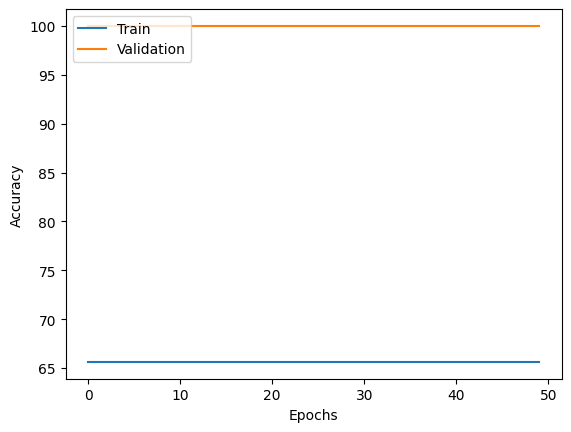

In [440]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [441]:
with t.no_grad():
    # Training data
    train_actual_values = []
    train_predicted_values = []
    for X, Y in train_data_loader:
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        train_actual_values.extend(Y.cpu().numpy())  # Append actual values to the list
        train_predicted_values.extend(out[:, 0].cpu().numpy())  # Append predicted values to the list

    # Validation data
    validation_actual_values = []
    validation_predicted_values = []
    for X, Y in test_data_loader:
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        validation_actual_values.extend(Y.cpu().numpy())  # Append actual values to the list
        validation_predicted_values.extend(out[:, 0].cpu().numpy())  # Append predicted values to the list

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_actual_values, train_predicted_values)
train_mse = mean_squared_error(train_actual_values, train_predicted_values)
train_rmse = mean_squared_error(train_actual_values, train_predicted_values, squared=False)
train_r2 = r2_score(train_actual_values, train_predicted_values)

validation_mae = mean_absolute_error(validation_actual_values, validation_predicted_values)
validation_mse = mean_squared_error(validation_actual_values, validation_predicted_values)
validation_rmse = mean_squared_error(validation_actual_values, validation_predicted_values, squared=False)
validation_r2 = r2_score(validation_actual_values, validation_predicted_values)

print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R2:", train_r2)

print("Validation MAE:", validation_mae)
print("Validation MSE:", validation_mse)
print("Validation RMSE:", validation_rmse)
print("Validation R2:", validation_r2)


Train MAE: 1.0714649441652
Train MSE: 4.113799642776743
Train RMSE: 2.0282503895665207
Train R2: -0.3335013720175324
Validation MAE: 0.09717193556328614
Validation MSE: 0.010162980202721729
Validation RMSE: 0.10081160748009987
Validation R2: 0.0


#Use the entire dataset to build and test the model via imputation

In [450]:
#Use cross validation to split the data into 80-20% train test split

# Define the feature columns and target column
model_data = merged_data[['change_prop_atleast1dose', 'date', 'Covid vaccine', 'Vaccine Booking', 'vaccine side effects', 'covid booster']]

# Define the number of splits for time series cross-validation
n_splits = 5

# Define the size of the training window for an 80-20 split
train_window_size = int(0.8 * len(model_data))

imputer = KNNImputer(n_neighbors=7)

# Perform time series cross-validation
cv_scores = []

for i in range(n_splits):
    # Define the start and end indices for the training and testing sets
    train_start = 0
    train_end = train_window_size
    test_start = train_end
    test_end = min(test_start + int(0.2 * len(model_data)), len(model_data))

    # Split the data into training and testing sets
    train_df, test_df = model_data.iloc[train_start:train_end], model_data.iloc[test_start:test_end]

    # Impute missing values in the training set
    y_train_imputed = imputer.fit_transform(train_df[['change_prop_atleast1dose']]).reshape(-1, 1)

    # Apply the same imputation to the testing set
    y_test_imputed = imputer.transform(test_df[['change_prop_atleast1dose']]).reshape(-1, 1)


In [451]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('change_prop_atleast1dose')
numerical_columns = [col for col in numerical_columns if col not in columns_to_remove]

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

In [452]:
train_df['change_prop_atleast1dose'] = y_train_imputed
test_df['change_prop_atleast1dose'] = y_test_imputed
# Displaying the shape of the training and test sets
train_shape = train_df.shape
test_shape = test_df.shape

print(train_shape, test_shape)

(145, 6) (36, 6)


In [453]:
# Checking the first few rows of the normalized training data
print(train_df.head())
test_df.tail()

   change_prop_atleast1dose       date  Covid vaccine  Vaccine Booking  \
0                       0.1 2020-12-27      -0.034007        -0.556794   
1                       0.2 2021-01-03      -0.342191        -0.556794   
2                       0.5 2021-01-10      -0.265145        -0.556794   
3                       0.6 2021-01-17      -0.226622        -0.556794   
4                       0.5 2021-01-24      -0.111053        -0.539957   

   vaccine side effects  covid booster  
0              1.200583      -0.499440  
1             -0.162114      -0.544787  
2             -0.162114      -0.544787  
3             -0.162114      -0.544787  
4              0.519234      -0.544787  


,change_prop_atleast1dose,date,Covid vaccine,Vaccine Booking,vaccine side effects,covid booster
120,1.023457,2023-11-05,-0.573330,-0.388421,-0.162114,-0.091319
121,1.023457,2023-11-12,-0.573330,-0.388421,-0.162114,-0.091319
122,1.023457,2023-11-19,-0.650376,-0.388421,-0.162114,-0.499440
123,1.023457,2023-11-26,-0.688899,-0.539957,-0.775327,-0.499440
124,0.500000,2023-12-03,-0.688899,-0.539957,-0.775327,-0.499440


In [460]:
def create_sequences(health_data, sequence_length=3):
    sequences = []
    output = []
    for i in range(0, len(health_data) - sequence_length + 1, sequence_length):
        sequence = health_data[i:i + sequence_length]
        label = sequence['change_prop_atleast1dose'].iloc[0]
        sequences.append(sequence[columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=3)
X_test, y_test = create_sequences(test_df, sequence_length=3)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((48, 3, 4), (48,), (12, 3, 4), (12,))

In [463]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
epochs = 50
learning_rate = 0.0001
batch_size = 32
landa = 0.1  # Regularization term (lambda)

# Data preparation
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(y_train).type(t.long)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(y_test).type(t.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, 1)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
# optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Convert the target tensor Y to float type
        Y = Y.float()
        # Regularization and loss
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        #loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Evaluation on training and validation data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            out, _ = rnn_layer2(out)
            out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        if validation_total != 0:
           validation_accuracy = 100 * validation_correct / validation_total
        else:
          validation_accuracy = 0

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()

Epoch 0/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 1/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 2/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 3/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 4/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 5/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 6/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 7/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 8/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 9/50 ---> Train Accuracy: 45.833333333333336%, Validation Accuracy: 16.666666666666668%
Epoch 10/50 ---> Train Accuracy: 45.833333333333336%, Valida

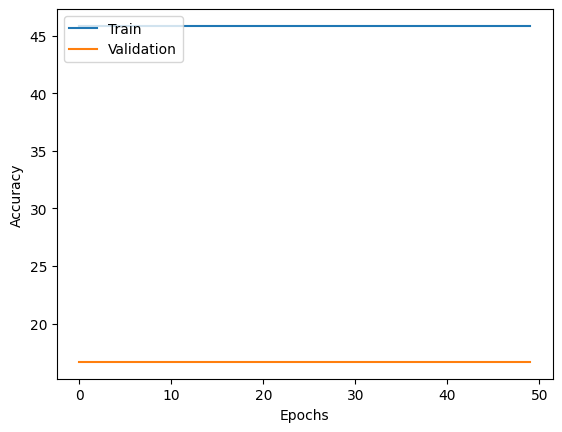

In [464]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [449]:
with t.no_grad():
    # Training data
    train_actual_values = []
    train_predicted_values = []
    for X, Y in train_data_loader:
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        train_actual_values.extend(Y.cpu().numpy())  # Append actual values to the list
        train_predicted_values.extend(out[:, 0].cpu().numpy())  # Append predicted values to the list

    # Validation data
    validation_actual_values = []
    validation_predicted_values = []
    for X, Y in test_data_loader:
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]
        out = relu(fc_layer1(out))
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        validation_actual_values.extend(Y.cpu().numpy())  # Append actual values to the list
        validation_predicted_values.extend(out[:, 0].cpu().numpy())  # Append predicted values to the list

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_actual_values, train_predicted_values)
train_mse = mean_squared_error(train_actual_values, train_predicted_values)
train_rmse = mean_squared_error(train_actual_values, train_predicted_values, squared=False)
train_r2 = r2_score(train_actual_values, train_predicted_values)

validation_mae = mean_absolute_error(validation_actual_values, validation_predicted_values)
validation_mse = mean_squared_error(validation_actual_values, validation_predicted_values)
validation_rmse = mean_squared_error(validation_actual_values, validation_predicted_values, squared=False)
validation_r2 = r2_score(validation_actual_values, validation_predicted_values)

print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R2:", train_r2)

print("Validation MAE:", validation_mae)
print("Validation MSE:", validation_mse)
print("Validation RMSE:", validation_rmse)
print("Validation R2:", validation_r2)


Train MAE: 0.7176945813828044
Train MSE: 1.419457736846991
Train RMSE: 1.191409978490608
Train R2: 0.01611593691472102
Validation MAE: 0.23628410365846422
Validation MSE: 0.08152930489612469
Validation RMSE: 0.28553336914645316
Validation R2: -0.5538526344908468
